<a href="https://colab.research.google.com/github/Akkki28/SparseMax-Transformers/blob/main/MultiHeadAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
import seaborn as sns
import torch.nn.functional as F
from torch.autograd import Function
#import the attention notebooks
#import SparseMax_Attention
#from SparseMax_Attention import scaled_dot_product
#from SparseMax_Attention import Sparsemax

In [5]:
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [6]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [7]:
batch_size = 2
seq_length = 5
input_dim = 10
embed_dim = 16
num_heads = 4

In [8]:
x = torch.randn(batch_size, seq_length, input_dim)
mha = MultiheadAttention(input_dim, embed_dim, num_heads)
output, attention = mha(x, return_attention=True)

In [9]:
def plot_attention(attention, num_heads, batch_idx=0):
    fig, axes = plt.subplots(1, num_heads, figsize=(10,5))
    fig.suptitle(f'Attention Maps for Batch {batch_idx}', fontsize=32)
    for i in range(num_heads):
        ax = axes[i]
        ax.matshow(attention[batch_idx, i].detach().cpu().numpy(), cmap='viridis')
        ax.set_title(f'Head {i+1}',fontsize=32)
        ax.axis('off')
    plt.show()

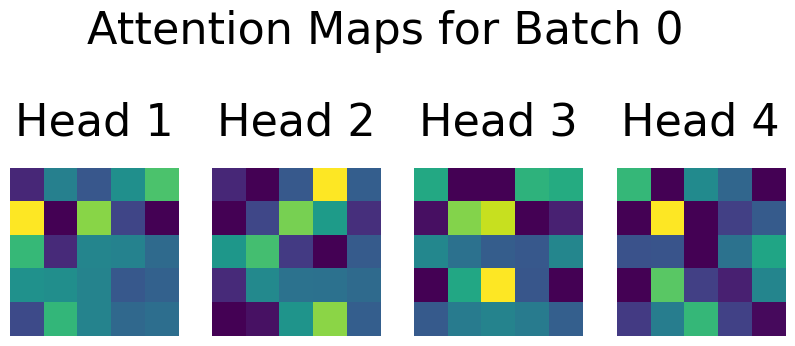

In [10]:
plot_attention(attention, num_heads)